In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

# 4.1 - Principal Component Analysis

Rotation Angle: -69 degrees
Rotation Angle: -23 degrees
Rotation Angle: -69 degrees
Rotation Angle: -128 degrees
Rotation Angle: -86 degrees
Rotation Angle: -89 degrees
Rotation Angle: -90 degrees
Rotation Angle: 44 degrees
Rotation Angle: 5 degrees
Rotation Angle: -127 degrees
Rotation Angle: -121 degrees
Rotation Angle: 0 degrees
Rotation Angle: -128 degrees
Rotation Angle: -90 degrees
Rotation Angle: -111 degrees
Rotation Angle: -90 degrees
Rotation Angle: -115 degrees
Rotation Angle: 42 degrees
Rotation Angle: -7 degrees
Rotation Angle: -84 degrees
Rotation Angle: -89 degrees
Rotation Angle: 2 degrees
Rotation Angle: -58 degrees
Rotation Angle: -55 degrees
Rotation Angle: -125 degrees
Rotation Angle: -126 degrees
Rotation Angle: -113 degrees
Rotation Angle: 41 degrees
Rotation Angle: -94 degrees
Rotation Angle: -90 degrees
Rotation Angle: -114 degrees
Rotation Angle: -98 degrees
Rotation Angle: -119 degrees
Rotation Angle: 33 degrees
Rotation Angle: -118 degrees
Rotation Angle: -92

/tmp/ipykernel_15919/457565456.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


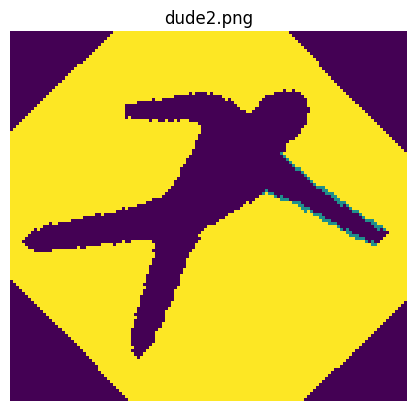

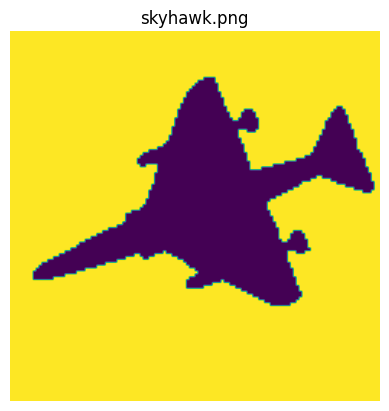

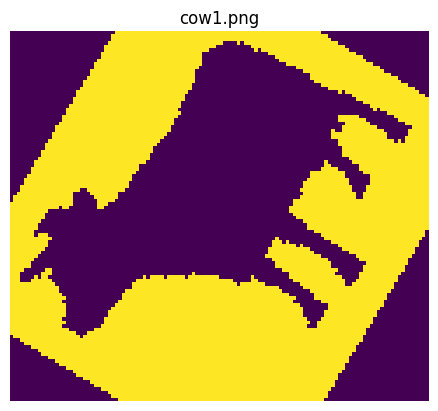

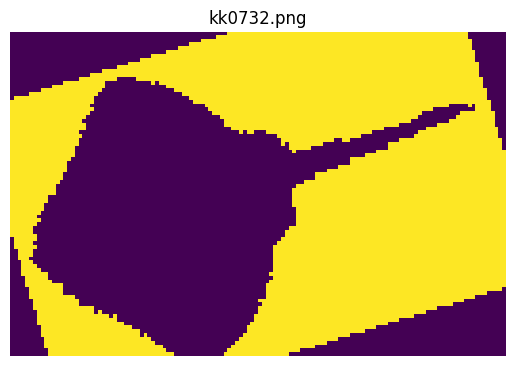

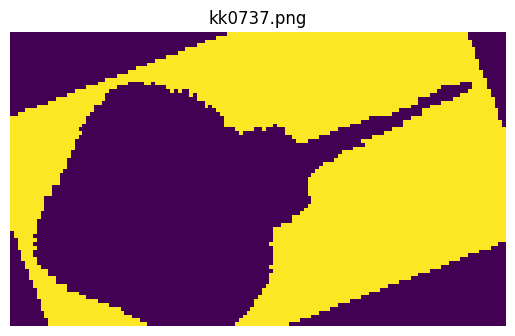

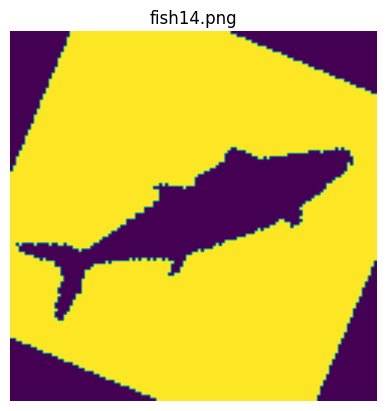

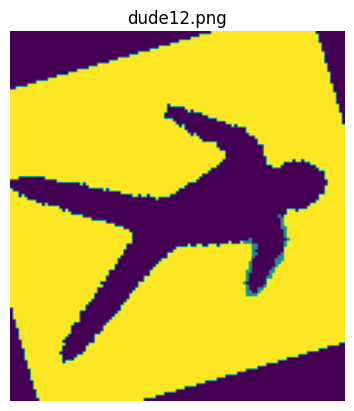

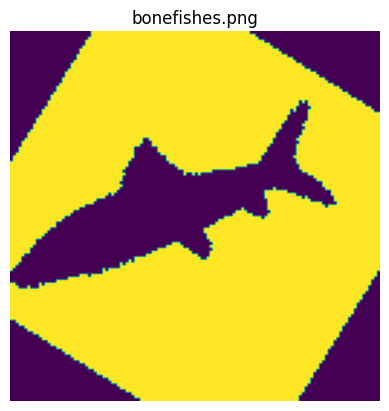

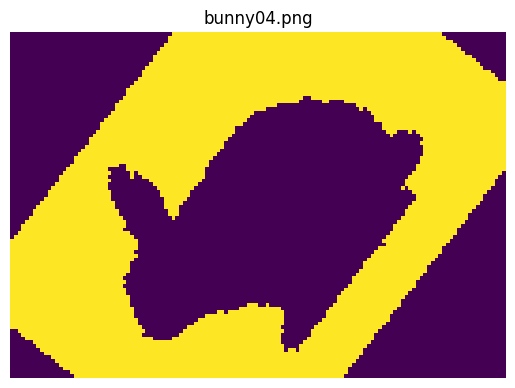

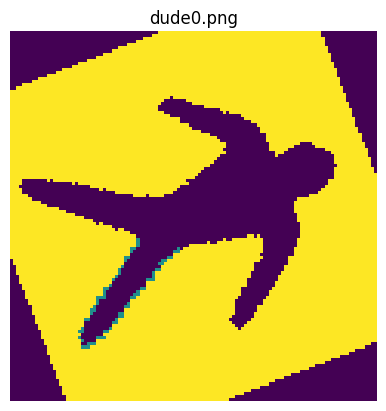

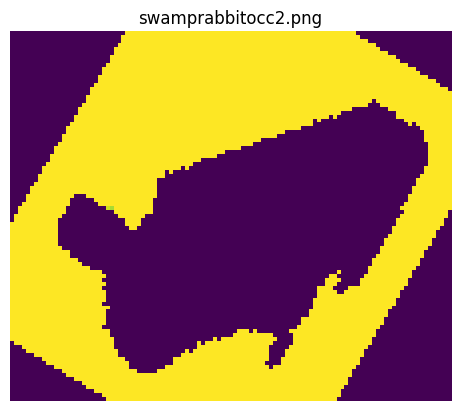

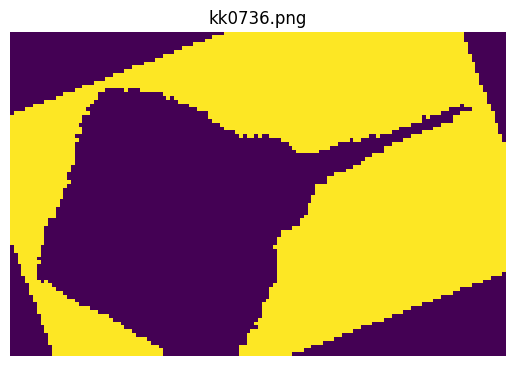

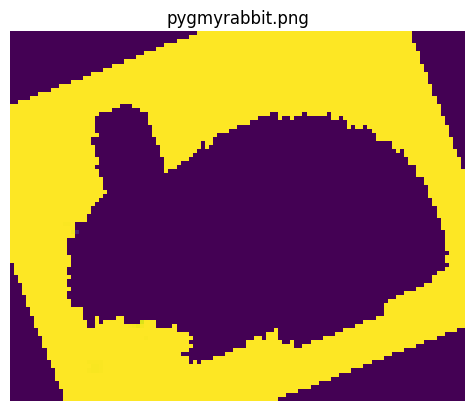

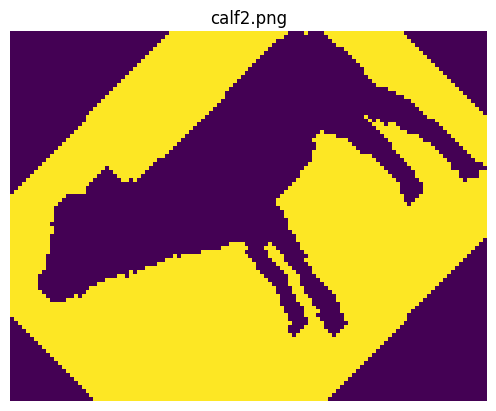

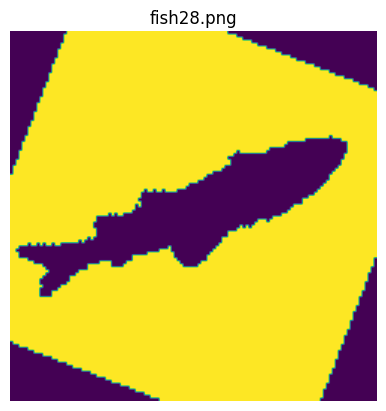

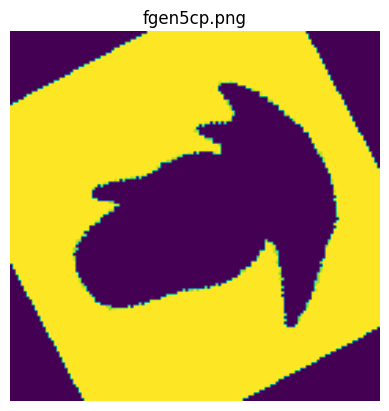

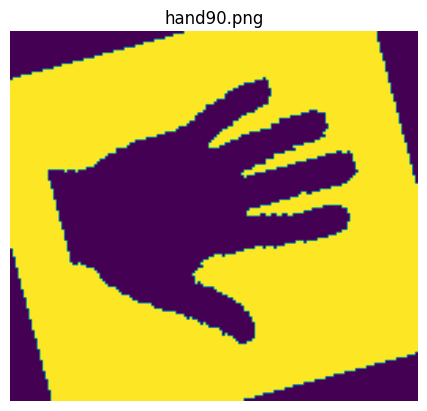

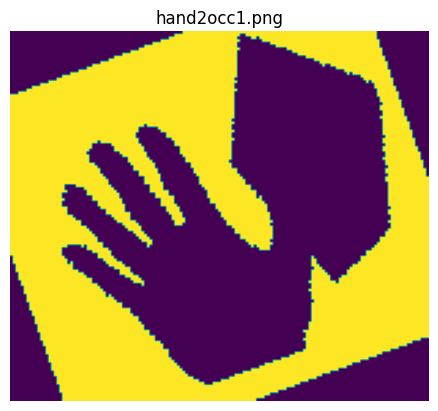

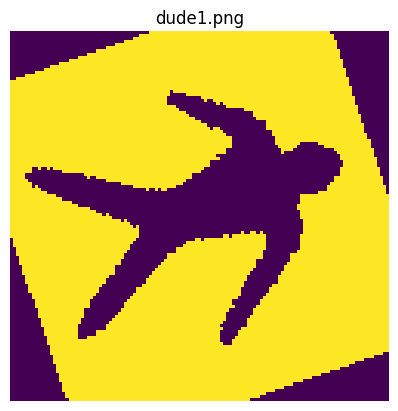

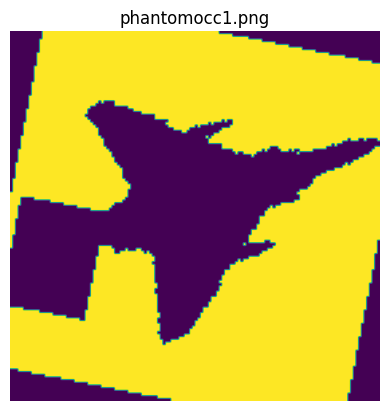

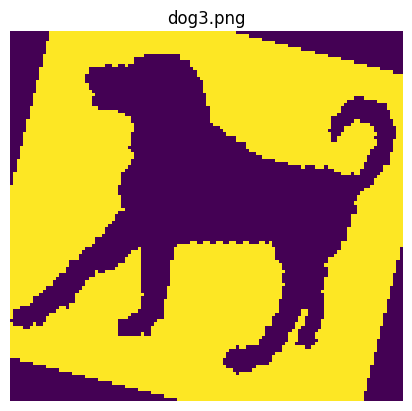

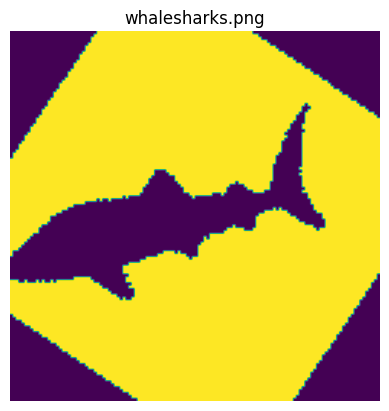

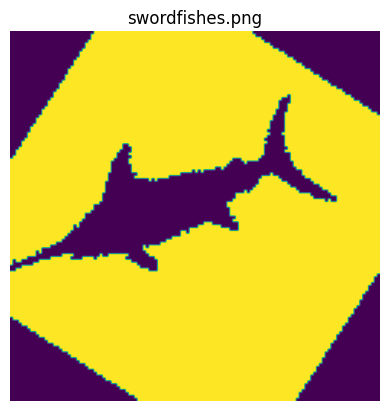

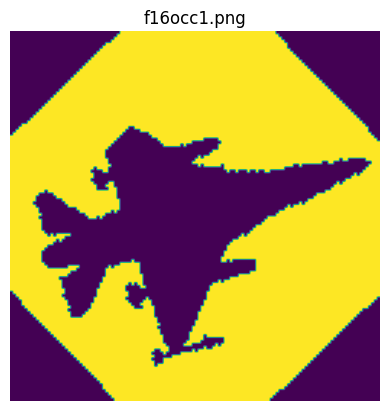

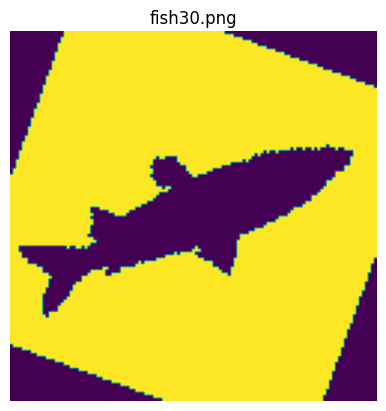

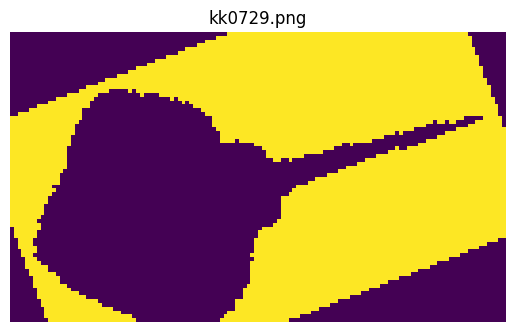

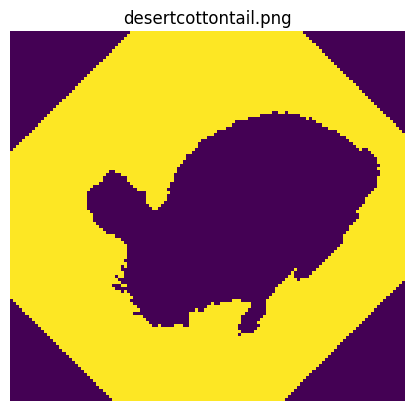

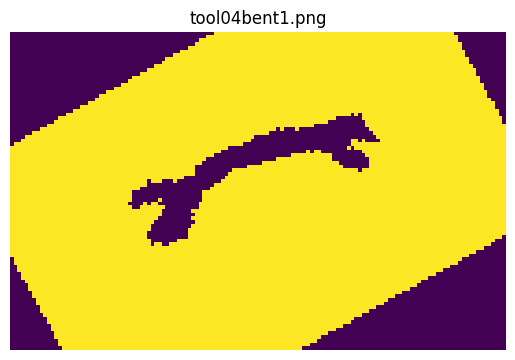

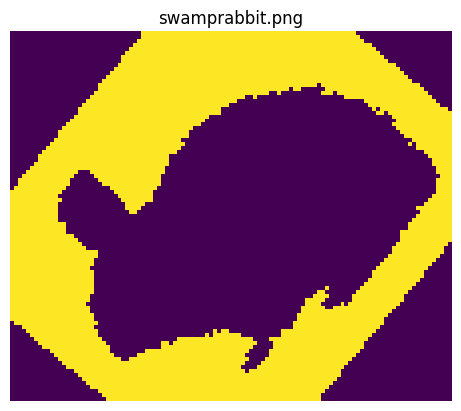

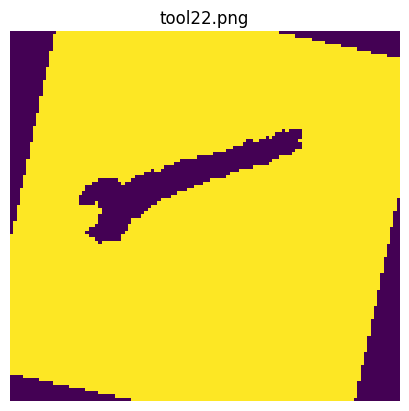

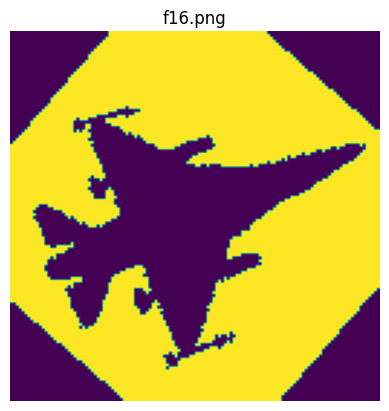

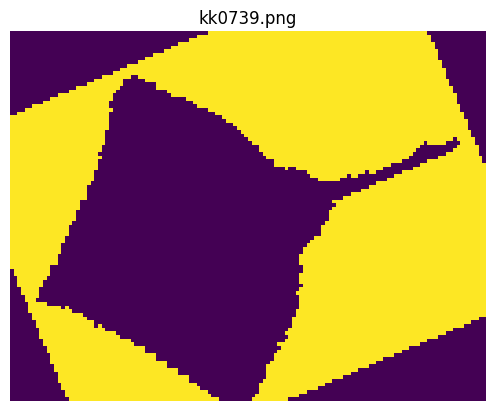

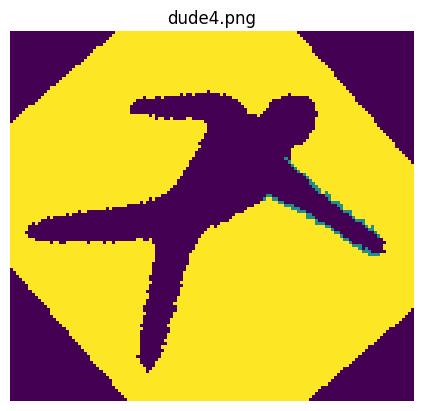

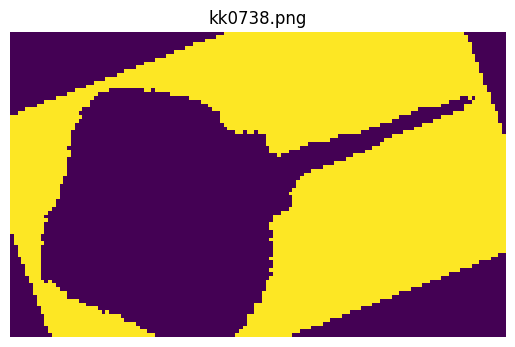

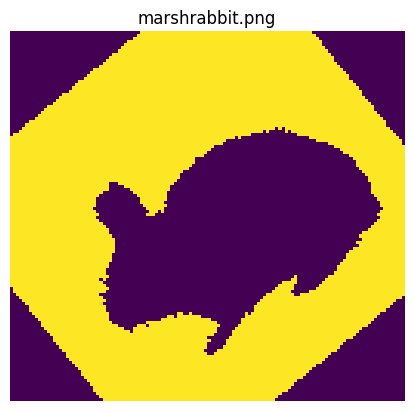

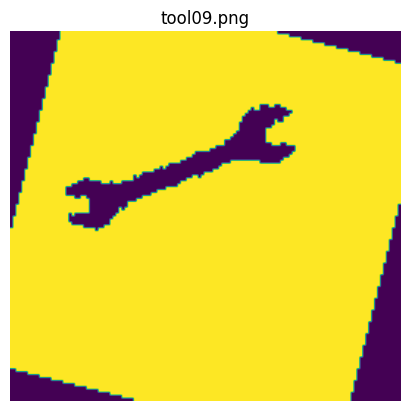

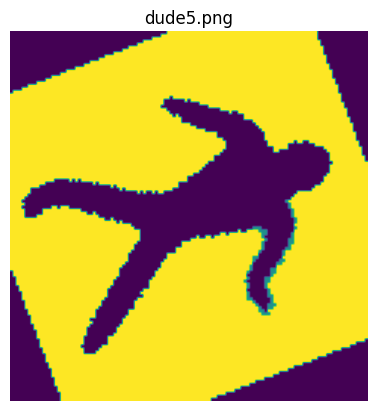

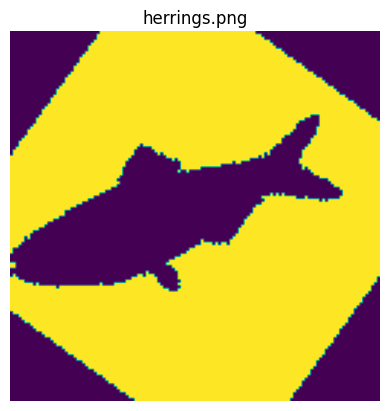

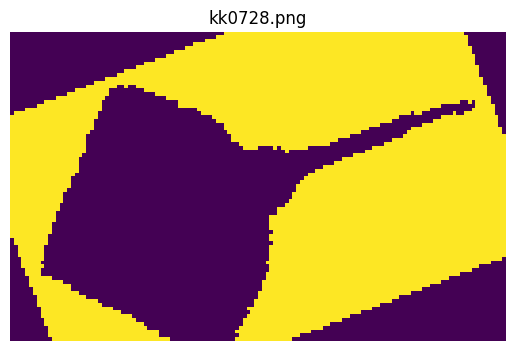

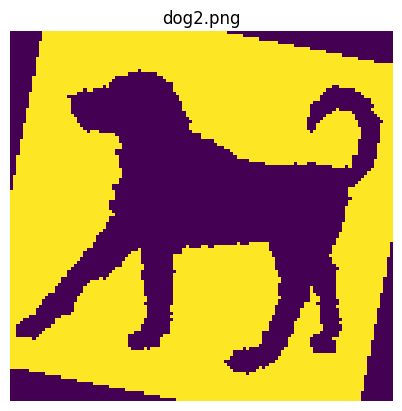

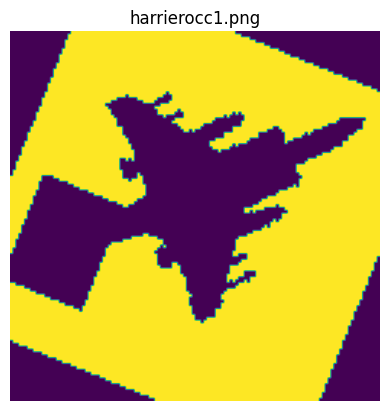

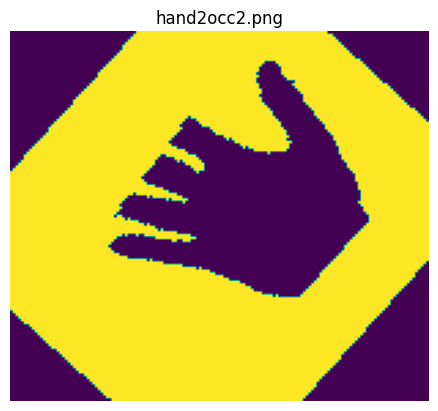

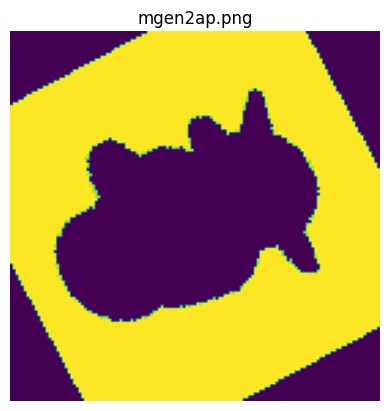

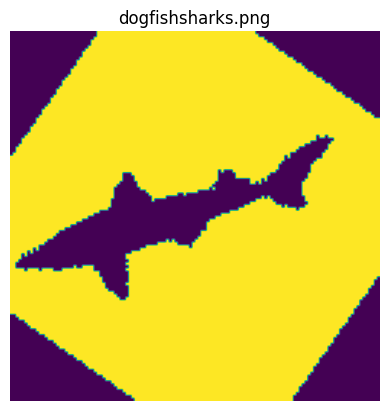

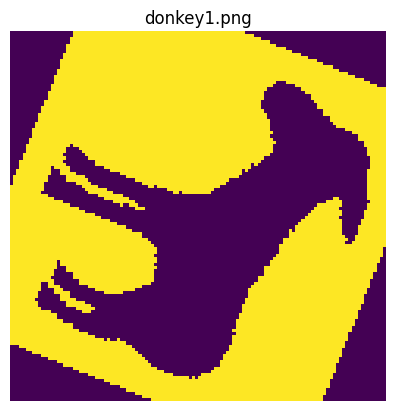

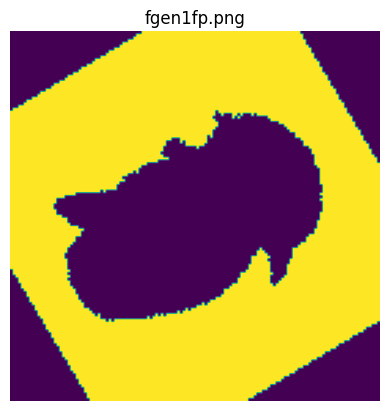

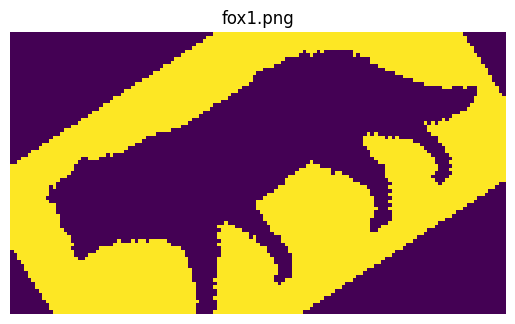

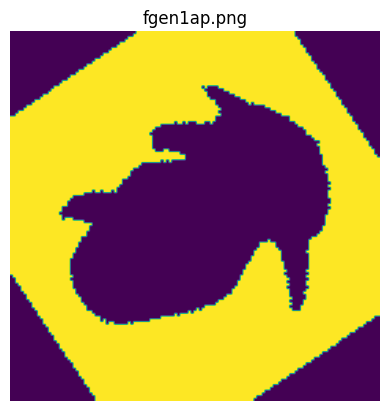

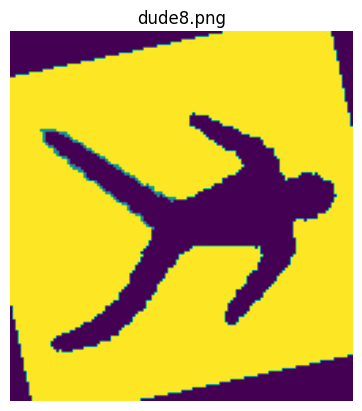

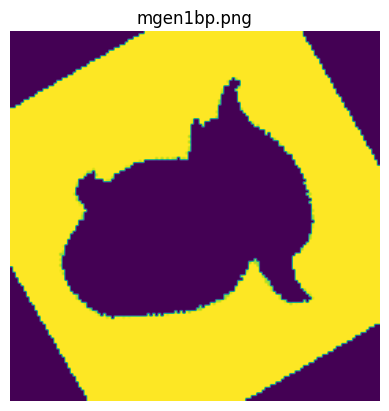

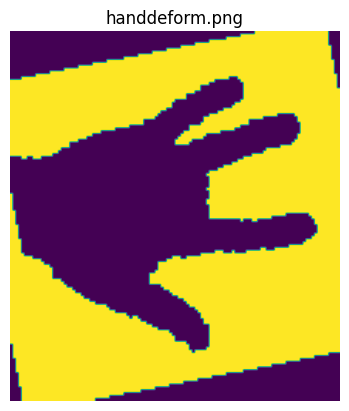

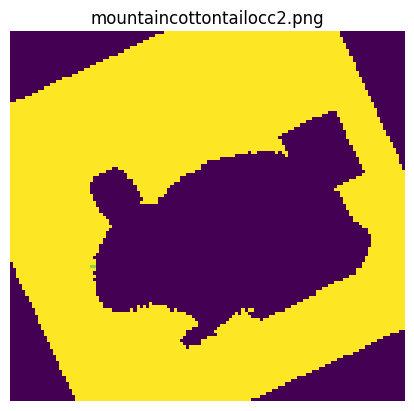

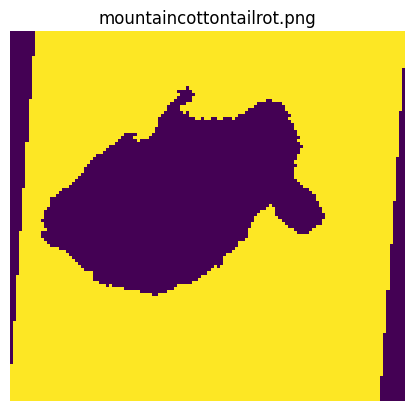

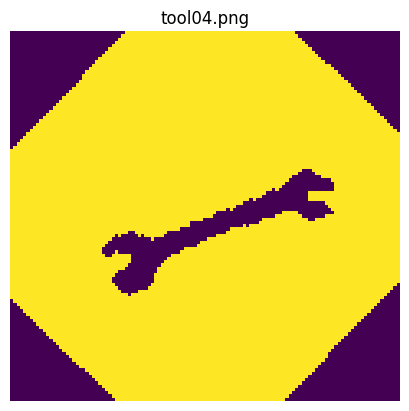

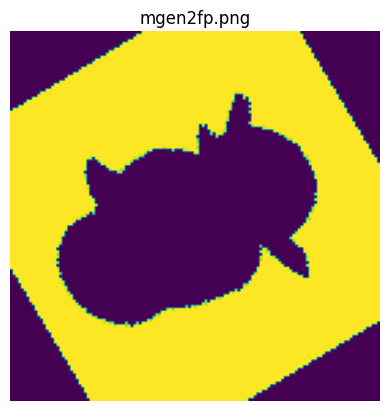

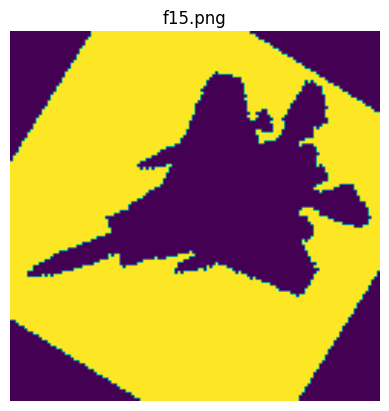

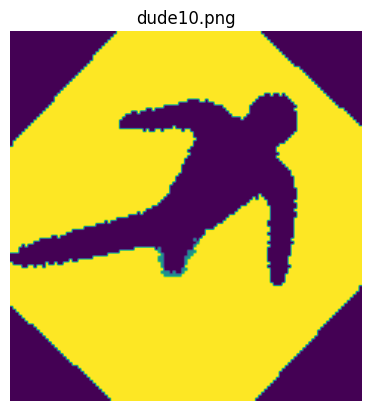

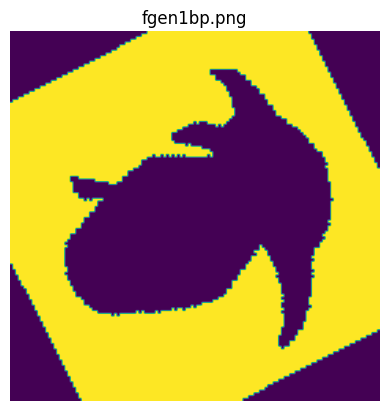

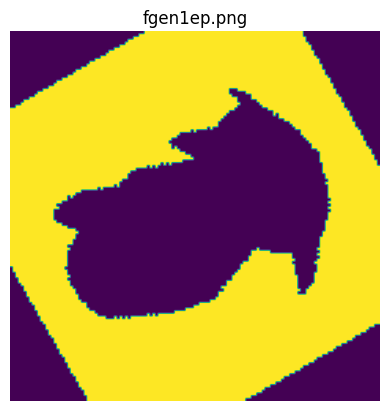

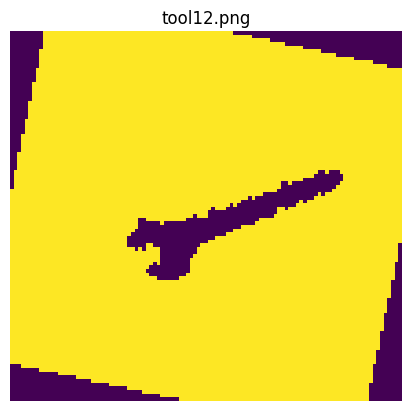

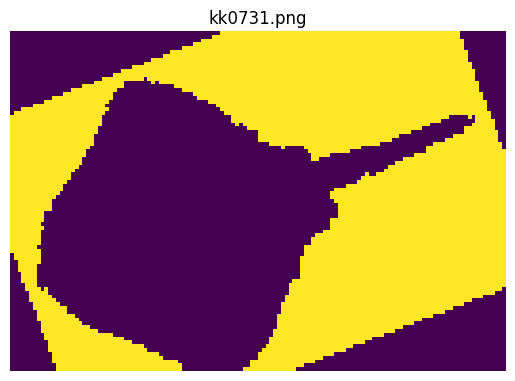

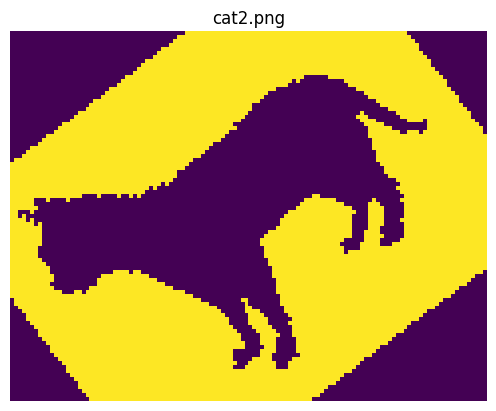

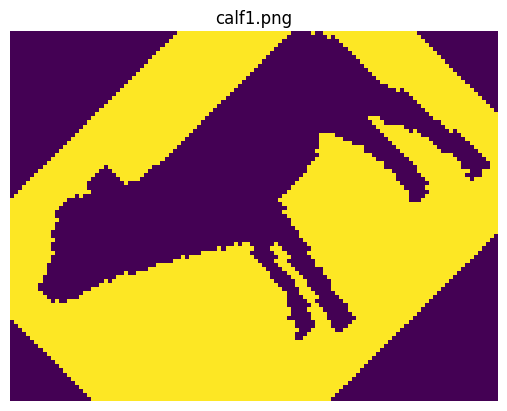

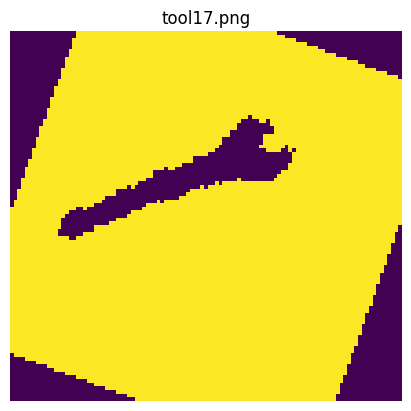

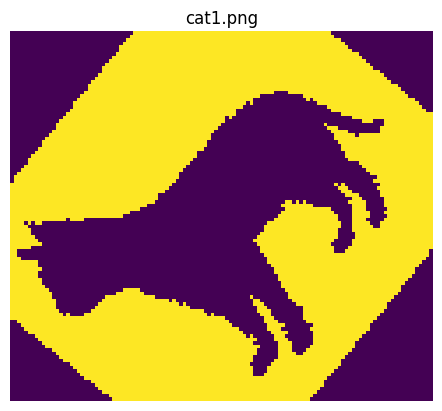

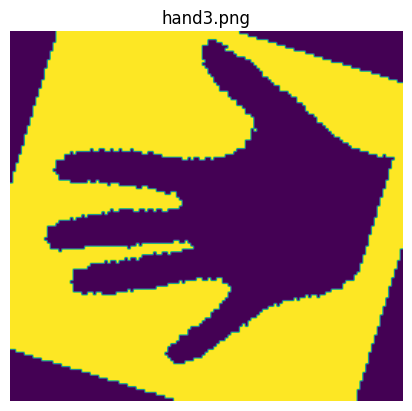

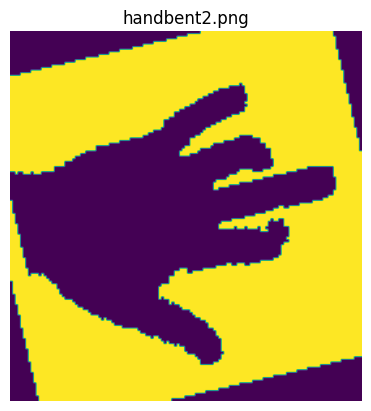

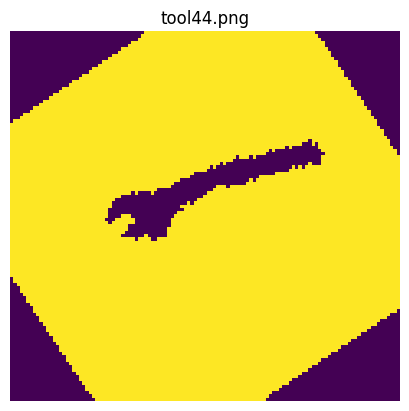

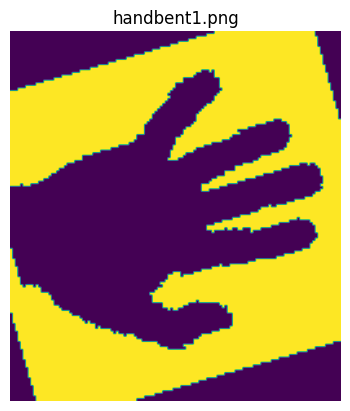

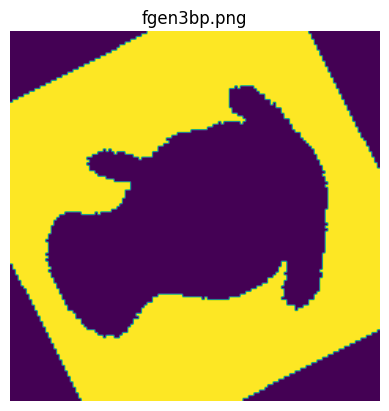

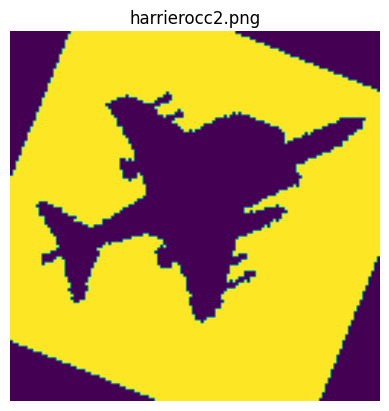

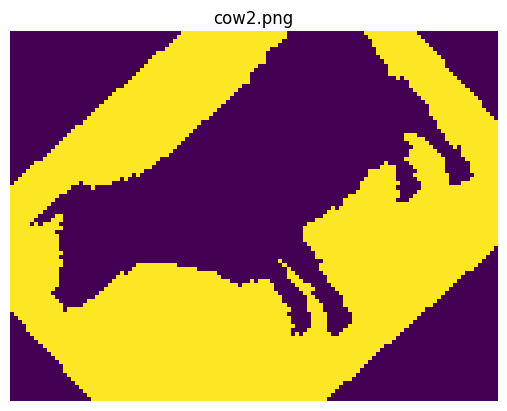

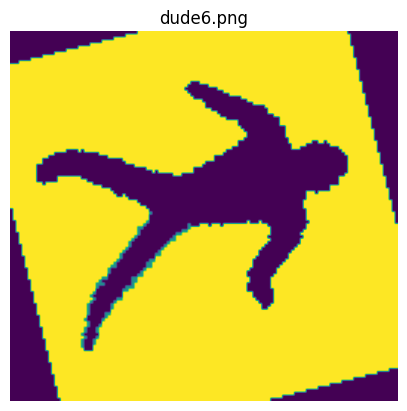

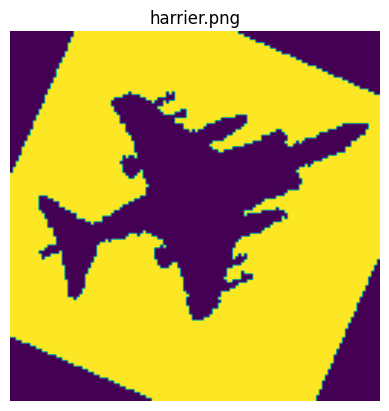

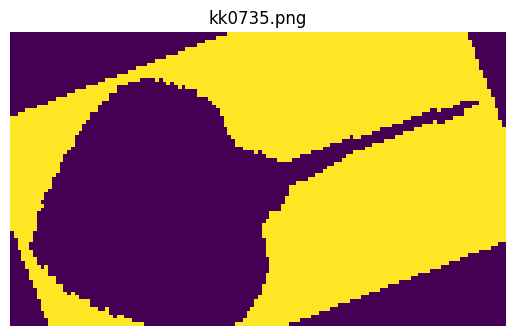

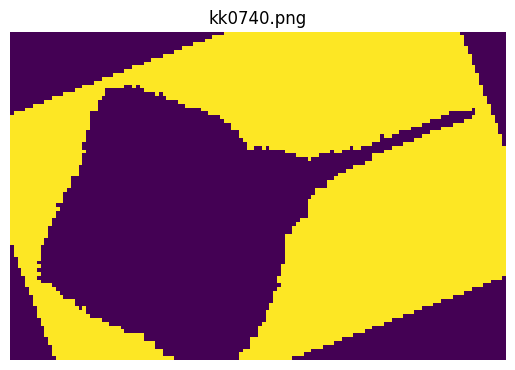

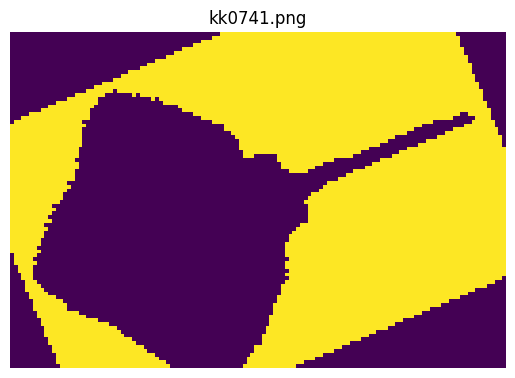

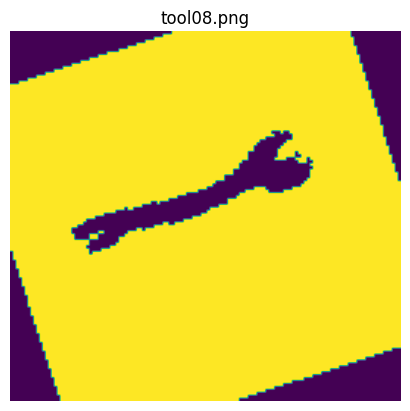

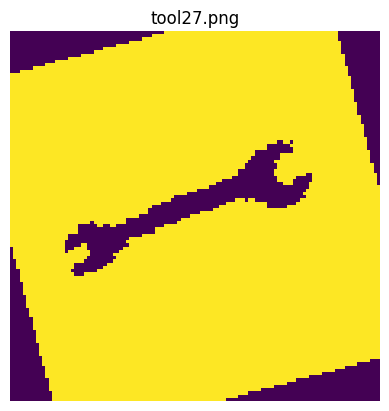

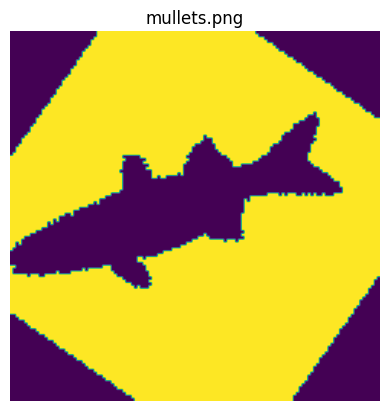

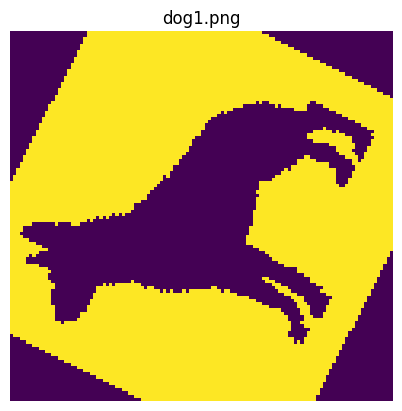

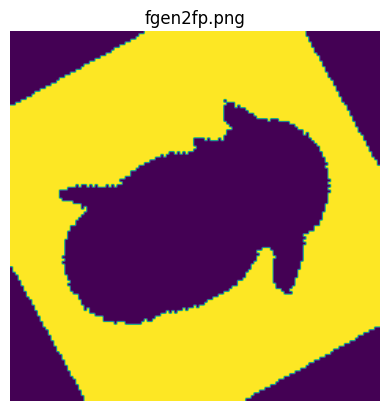

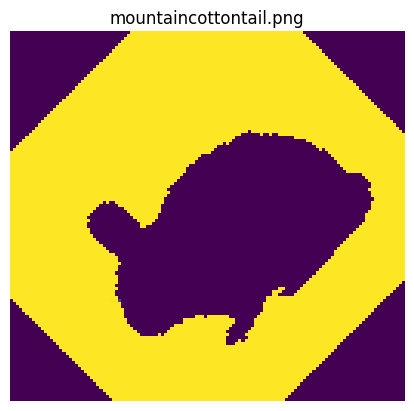

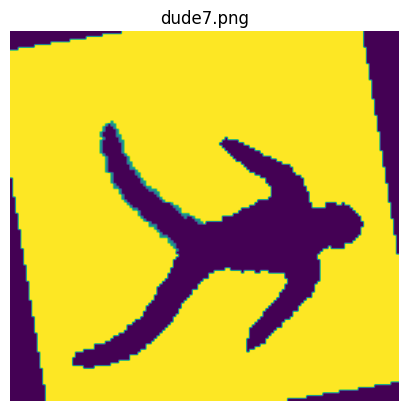

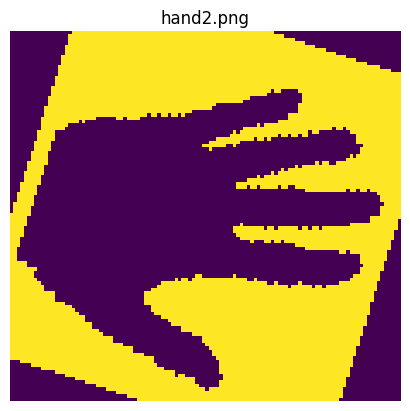

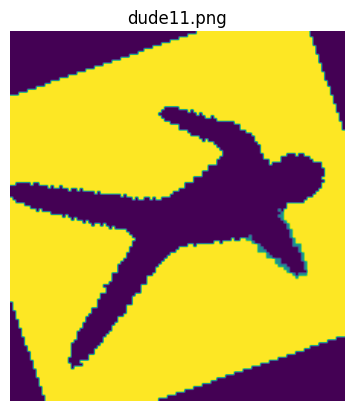

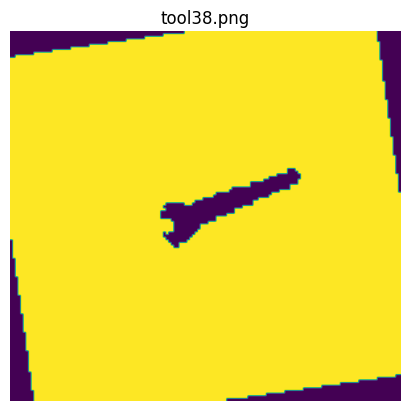

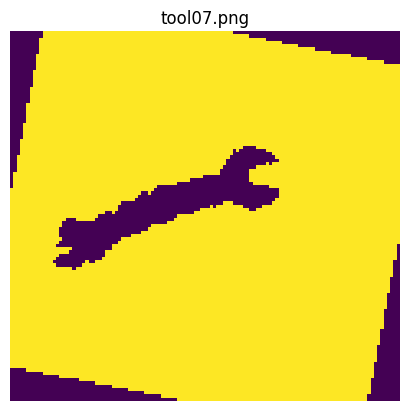

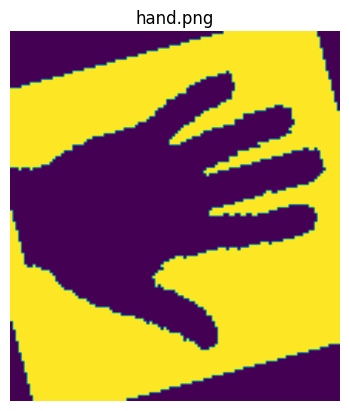

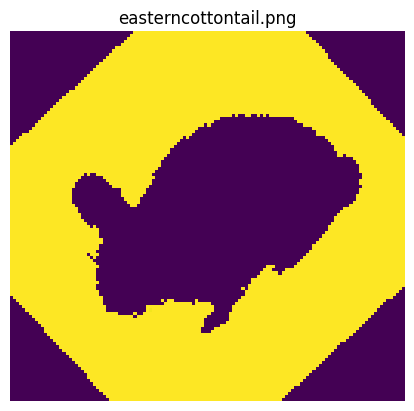

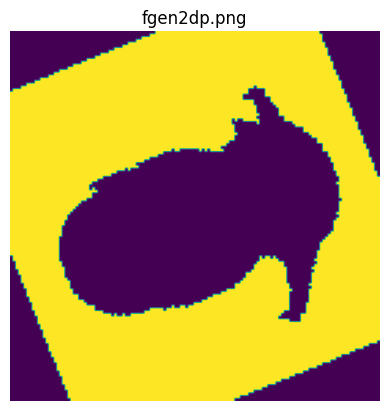

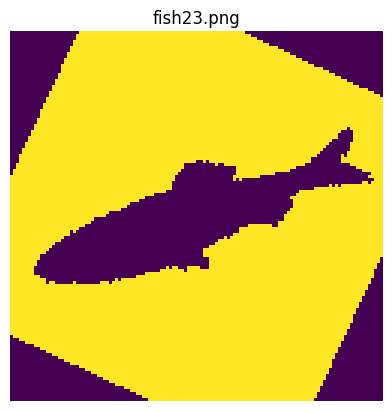

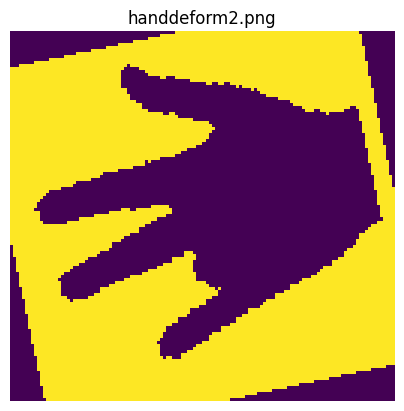

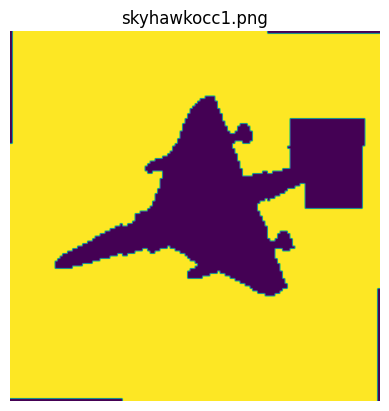

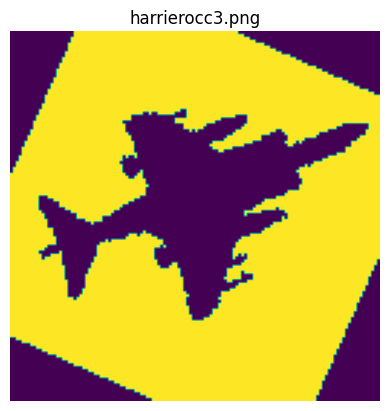

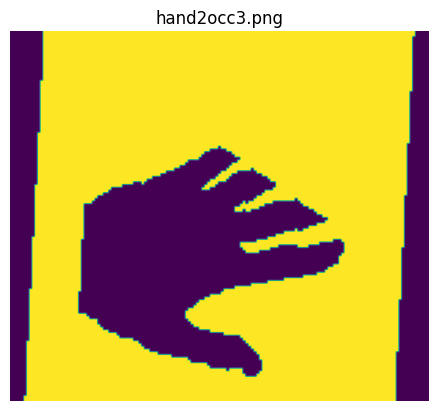

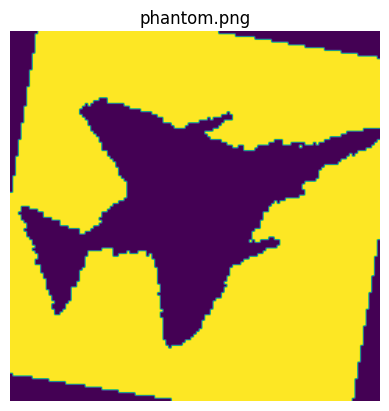

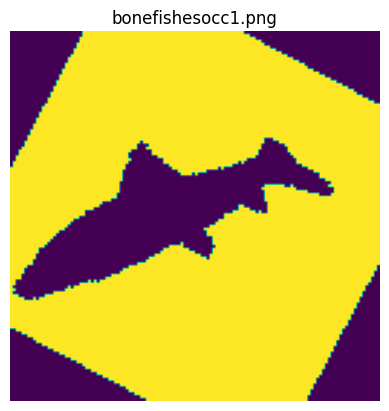

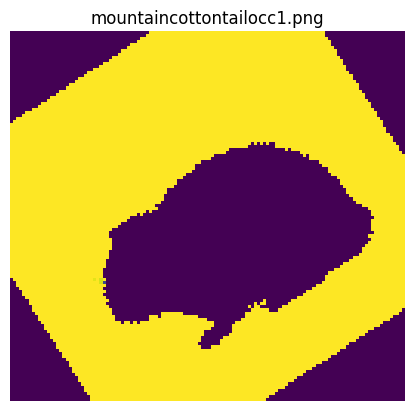

In [2]:
import cv2 as cv
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
def convert_from_cv2_to_image(image: np.ndarray) -> Image:
    # return Image.fromarray(img)
    return Image.fromarray(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def convert_from_image_to_cv2(image: Image) -> np.ndarray:
    # return np.asarray(img)
    return cv.cvtColor(np.array(image), cv.COLOR_RGB2BGR)

def drawAxis(img,start_,end_,color,scale):
   start = list(start_)
   end = list(end_)
   dx = start[0]-end[0]
   dy = start[1]-end[1]

   hypotenuse = math.sqrt(dy**2 + dx**2)
   angle = math.atan2(dy,dx)
   # Lengthen the arrow by a factor of scale
   end[0] = start[0]-math.cos(angle)*hypotenuse*scale
   end[1] = start[1]-math.sin(angle)*hypotenuse*scale
   cv.line(img, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), color, 3, cv.LINE_AA)
   # Create the Arrow Hooks
   hook_length = 9
   angle_1 = math.pi/4+angle
   angle_2 = angle-math.pi/4

   x1 = end[0] + hook_length*math.cos(angle_1)
   y1 = end[1] + hook_length*math.sin(angle_1)
   x2 = end[0] + hook_length*math.cos(angle_2)
   y2 = end[1] + hook_length*math.sin(angle_2)
   cv.line(img, (int(x1), int(y1)), (int(end[0]), int(end[1])), color, 3, cv.LINE_AA)
   cv.line(img, (int(x2), int(y2)), (int(end[0]), int(end[1])), color, 3, cv.LINE_AA)
    

def getOrientation(points,image):
   data_points = np.empty((len(points), 2), dtype=np.float64)
   for i in range(data_points.shape[0]):
    data_points[i,0] = points[i,0,0]
    data_points[i,1] = points[i,0,1]
   
   mean = np.empty((0))
   mean, eigenvectors, eigenvalues = cv.PCACompute2(data_points, mean)

   # Calculate the center of the object
   center = (int(mean[0, 0]), int(mean[0, 1]))
   cv.circle(image, center, 3, (255, 0, 255), 2)

   # Calculate the endpoints of the principal components
   p1 = (center[0] + 0.02 * eigenvectors[0, 0] * eigenvalues[0, 0], center[1] + 0.02 * eigenvectors[0, 1] * eigenvalues[0, 0])
   p2 = (center[0] - 0.02 * eigenvectors[1, 0] * eigenvalues[1, 0], center[1] - 0.02 * eigenvectors[1, 1] * eigenvalues[1, 0])

   # Draw the principal components
   drawAxis(image, center, p1, (255, 255, 0), 1)
   drawAxis(image, center, p2, (0, 0, 255), 5)

    # Calculate the orientation angle in radians
   angle = math.atan2(eigenvectors[0, 1], eigenvectors[0, 0])

    # Label with the rotation angle
   rotation_angle = -int(np.rad2deg(angle)) - 90
   label = f"Rotation Angle: {rotation_angle} degrees"
   print(label)

    # Draw a text box with the rotation angle
   textbox = cv.rectangle(image, (center[0], center[1] - 25), (center[0] + 250, center[1] + 10), (255, 255, 255), -1)
   cv.putText(image, label, (center[0], center[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv.LINE_AA)

   return str(rotation_angle)


def process_image(image_path):
    # Load the image
    image = cv.imread(image_path)
    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: File not found - {img_path}")
        return None
    # Convert the image to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Convert the image to binary using Otsu's thresholding
    _, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    # Find all the contours in the thresholded image
    contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    max_area = 0
    max_orientation = 0
    # Iterate through the contours
    for i, c in enumerate(contours):
        # Calculate the area of each contour
        area = cv.contourArea(c)
        # Ignore contours that are too large
        if area > 10000:
            continue
        # Draw each contour only for visualization purposes
        cv.drawContours(image, contours, i, (0, 0, 255), 2)
        # Find the orientation of each shape
        orientation = getOrientation(c, image)
        if area > max_area:
            max_area = area
            max_orientation = orientation
    return max_orientation
      

folder_path = "KIMIA-99"
output_folder = "Image-KIMIA"
# Create the output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

processed_images = []
ans = process_image("KIMIA-99/skyhawk.png")

# Iterate through all PNG files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        file_path = os.path.join(folder_path, filename)
        # Process the image and get the orientation
        orientation = process_image(file_path)
        difference = int(ans)-int(orientation)
        original_image = Image.open(file_path)
        rotated_image = original_image.rotate(difference)
        # Save the rotated image
        output_file_path = os.path.join(output_folder, filename)
        rotated_image.save(output_file_path)
        processed_images.append((filename, output_file_path))

# Close OpenCV windows after processing
cv.destroyAllWindows()

# Display all processed images with labels
for filename, img_path in processed_images:
    img = Image.open(img_path)
    plt.figure()
    plt.title(filename)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Image Processing Algorithm Flowchart
![Flowchart](4-1.drawio.png)

## Initialization
```
1. Load "tool12.png" as the reference image.
2. Initialize an empty list for storing processed images.
3. Initialize a variable `ans` to store the reference orientation angle.
```
## Reference Orientation Calculation
```
4. Calculate the orientation (angle) of the shape in "tool12.png" using PCA:
   - Load the reference image.
   - Convert the reference image to grayscale.
   - Convert the reference image to binary using Otsu's thresholding.
   - Find all the contours in the thresholded reference image.
   - Iterate through the reference contours:
     - Calculate the area of each contour.
     - Ignore contours that are too large.
     - Draw each contour for visualization.
     - Find the orientation of each shape using PCA.
     - Update the maximum area and maximum orientation.
   - Calculate the reference orientation angle `ans` using the maximum orientation angle.
```
## Image Processing Loop
```
5. For each PNG file in the folder "KIMIA-99":
   - Load the current image.
   - Initialize a variable `difference` to store the angle difference.
   - Calculate the orientation (angle) of the shape in the current image using PCA:
     - Convert the current image to grayscale.
     - Convert the current image to binary using Otsu's thresholding.
     - Find all the contours in the thresholded current image.
     - Iterate through the current contours:
       - Calculate the area of each contour.
       - Ignore contours that are too large.
       - Draw each contour for visualization.
       - Find the orientation of each shape using PCA.
       - Update the maximum area and maximum orientation.
     - Calculate the orientation angle of the current image.
   - Calculate the angle difference `difference` between the current image and the reference image.
   - Rotate the current image by the calculated angle difference.
   - Save the rotated image to the "Image-KIMIA" folder.
   - Add the filename and output path to the list of processed images.
```
## Post-Processing
```
6. Close any open OpenCV windows.
```
## Display Processed Images
```
7. Display the processed images with labels using Matplotlib.
8. End.
```


# 4.2 - Hierarchial Clustering 

In [2]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import pdist, squareform

In [3]:
initial_data = pd.read_csv('Bounding-Boxes/CSV/TLBR_68.csv')
# print(initial_data)
column_names = [
    {'name': 'Id'},
    {'name':'Top-Left'},
    {'name':'Bottom-Right'},
    {'name': 'Top'},
    {'name': 'Left'},
    {'name': 'Bottom'},
    {'name': 'Right'},
    {'name': 'Top_Box'},
    {'name': 'Bottom_Box'},
    {'name': 'Left_Box'},
    {'name': 'Right_Box'}
]
euclidean = pd.DataFrame(columns=[col['name'] for col in column_names])
column_names = [
    {'name': 'Id'},
    {'name': 'Centre'}
]
center_data = pd.DataFrame(columns=[col['name'] for col in column_names])
def get_coordinates(cell_value):
    x,y = json.loads(cell_value)
    return int(x),int(y)

for index, row in initial_data.iterrows():
    bottom_right_x , bottom_right_y = get_coordinates(row['Bottom-Right'])
    top_left_x , top_left_y = get_coordinates(row['Top-Left'])
    bounding_box_id =  row['Id']
    Top , Bottom , Left , Right = (
        ((top_left_x + bottom_right_x) / 2, top_left_y),
        ((top_left_x + bottom_right_x) / 2, bottom_right_y),
        (top_left_x, (top_left_y + bottom_right_y) / 2),
        (bottom_right_x, (top_left_y + bottom_right_y) / 2)
    )
    Top_box , Bottom_box , Left_box , Right_box = (-1,0),(-1,0),(-1,0),(-1,0)
    euclidean.loc[index] = [bounding_box_id,(top_left_x,top_left_y),(bottom_right_x,bottom_right_y),Top,Left,Bottom,Right,Top_box,Bottom_box,Left_box,Right_box]
    center_data.loc[index] = [bounding_box_id,[(bottom_right_x+top_left_x)/2,(bottom_right_y+top_left_y)/2]]

center_data[['X','Y']] = pd.DataFrame(center_data['Centre'].tolist(), columns=['X', 'Y'])
def get_distance(z1, z2):
    return np.sqrt((z2[0] - z1[0]) ** 2 + (z2[1] - z1[1]) ** 2)

def find_closest_bounding_box(direction,reference_row):
    closest_bounding_box = [-1,0]
    minimum_distance = float('inf')
    for index,closest_row in euclidean.iterrows():
        if closest_row['Id'] == reference_row['Id']:
            continue
        distance = float('inf')
        calc = get_distance([(reference_row['Top'][0] + reference_row['Bottom'][0]) / 2, (reference_row['Top'][1] + reference_row['Bottom'][1]) / 2],
                                      [(closest_row['Top'][0] + closest_row['Bottom'][0]) / 2, (closest_row['Top'][1] + closest_row['Bottom'][1]) / 2])
        if direction == 'Top' and reference_row['Top'][1] < closest_row['Bottom'][1]:
            distance = calc
        elif direction == 'Bottom' and reference_row['Bottom'][1] > closest_row['Top'][1]:
            distance = calc
        elif direction == 'Left' and reference_row['Left'][0] < closest_row['Right'][0]:
            distance = calc
        elif direction == 'Right' and reference_row['Right'][0] > closest_row['Left'][0]:
            distance = calc
        if minimum_distance > distance:
            minimum_distance = distance
            closest_bounding_box = [minimum_distance, closest_row['Id'] + 1]
    return closest_bounding_box

vertical_distances = []
horizontal_distances = []

# Iterate through the 'euclidean' DataFrame to find the nearest boxes in each direction
for index, row in euclidean.iterrows():
    euclidean.at[index, 'Top_Box'] = find_closest_bounding_box('Top',row)
    euclidean.at[index, 'Bottom_Box'] = find_closest_bounding_box('Bottom',row)
    euclidean.at[index, 'Left_Box'] = find_closest_bounding_box('Left',row)
    euclidean.at[index, 'Right_Box'] = find_closest_bounding_box('Right',row)

    if euclidean.at[index, 'Top_Box'][0] != -1:
        vertical_distances.append(euclidean.at[index, 'Top_Box'][0])
    if euclidean.at[index, 'Left_Box'][0] != -1:
        horizontal_distances.append(euclidean.at[index, 'Left_Box'][0])

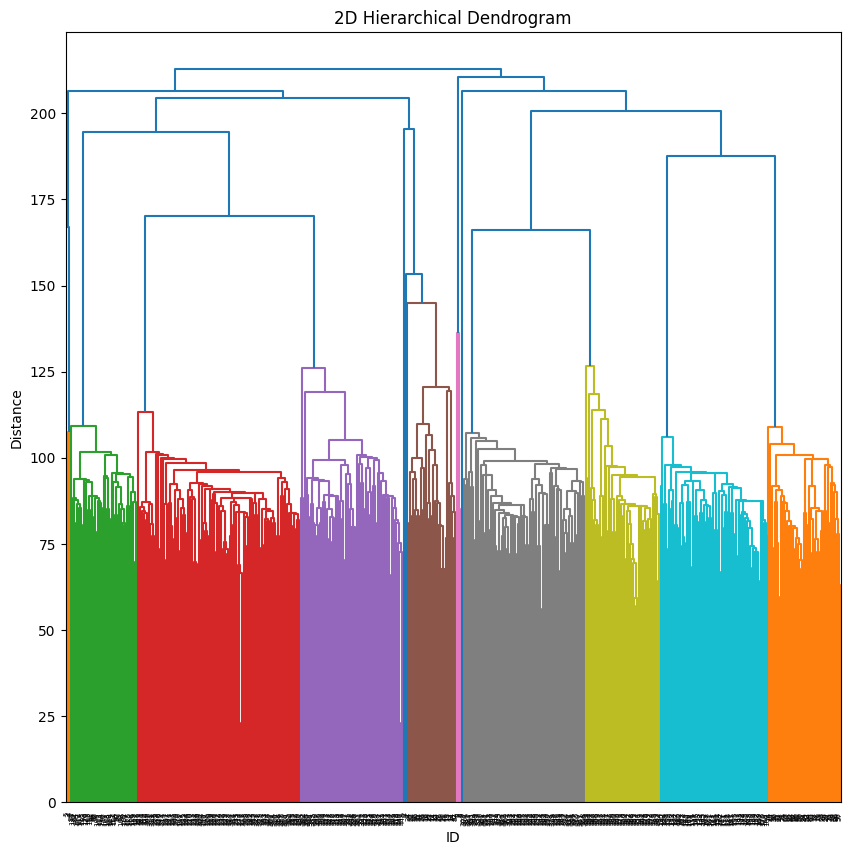

Number of Different Colors Used: 10
Cluster ID 103: IDs [367, 371, 358, 366, 493, 488, 494, 492, 487, 480, 458, 466, 473, 457, 465, 472, 495, 481, 477, 482, 496, 486, 490, 497, 469, 470, 471, 479, 450, 460, 464, 462, 452, 463, 456, 455, 453, 454, 451, 449, 461, 468, 475, 476, 459, 467, 474]
Cluster ID 142: IDs [447, 448, 2, 0, 1, 28, 35, 22, 29, 36, 30, 31, 37, 38, 23, 39, 16, 18, 25, 33, 11, 14, 15, 34, 27, 26, 19, 20, 21, 10, 13]
Cluster ID 444: IDs [286, 240, 281, 386, 392, 384, 398, 390, 437, 396, 389, 435, 440, 397, 436, 405, 406, 404, 439, 413, 421, 427, 428, 412, 420, 411, 419, 426, 414, 422, 429, 407, 441, 385, 391, 442, 438, 399, 400, 387, 401, 394, 393, 443, 423, 430, 431, 415, 424, 408, 416, 425, 388, 432, 417, 395, 444, 403, 491, 433, 434, 402, 445, 409, 418]
Cluster ID 306: IDs [87, 6]
Cluster ID 250: IDs [5, 160, 175, 176, 166, 167, 74, 76, 44, 52, 50, 40, 41, 42, 43, 51, 75, 69, 67, 68, 82, 83, 62, 58, 80, 81, 59, 60, 61, 84, 45, 53, 64, 85, 65, 72, 77, 78, 71, 79, 63, 7

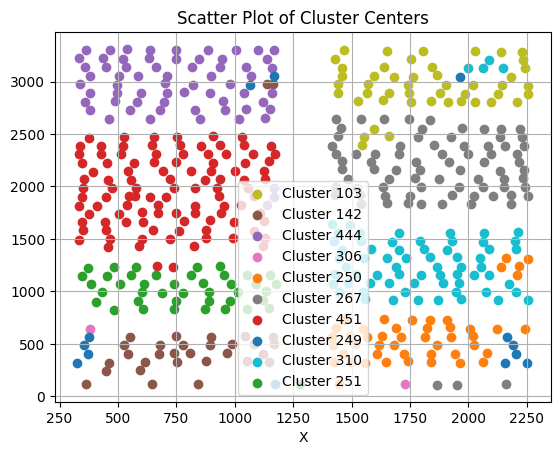

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


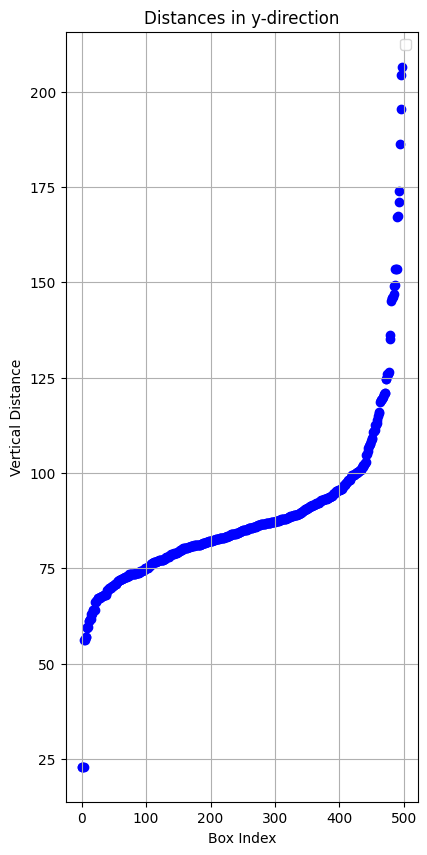

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


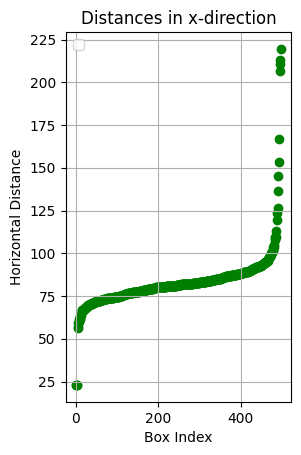

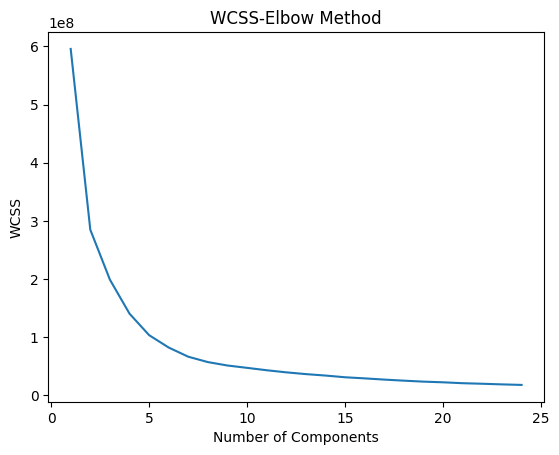

In [4]:
plt.figure(figsize=(10, 10))
plt.xlabel('ID'); plt.ylabel('Distance'); plt.title('2D Hierarchical Dendrogram')
clustering = dendrogram(linkage(center_data[['X', 'Y']], method='single', metric='minkowski'), 
                    labels=center_data['Id'].tolist(), 
                    orientation='top', 
                    distance_sort='ascending')
plt.show()
cluster_id_mapping = {}
def plot_scatter():
    cluster_labels = fcluster(linkage(center_data[['X', 'Y']], method='single', metric='minkowski'), t=5, criterion='distance')  # Adjust the threshold 't' as needed
    cluster_id_mapping = {id_: label for id_, label in zip(clustering['ivl'], cluster_labels)}
    unique_colors = set(clustering['color_list'])
    num_unique_colors = len(unique_colors)
    print(f'Number of Different Colors Used: {num_unique_colors}')
    for color in unique_colors:
        ids_in_cluster = [id_ for id_, label_color in zip(clustering['ivl'], clustering['color_list']) if label_color == color]
        cluster_id = cluster_id_mapping.get(ids_in_cluster[0], None)  # Get cluster ID from the mapping
        print(f'Cluster ID {cluster_id}: IDs {ids_in_cluster}')
        cluster_centers = center_data[center_data['Id'].isin(ids_in_cluster)]
        # print(cluster_centers)
        plt.scatter(cluster_centers['X'], cluster_centers['Y'], label=f'Cluster {cluster_id}', c=color)
    plt.xlabel('X');plt.title('Scatter Plot of Cluster Centers');plt.legend();plt.grid(True);plt.show()

plot_scatter()
vertical_distances.sort()
horizontal_distances.sort()
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.scatter(range(len(vertical_distances)), vertical_distances, marker='o', color='blue')
plt.xlabel('Box Index');plt.ylabel('Vertical Distance');plt.title('Distances in y-direction');plt.legend();plt.grid(True);plt.show()
plt.subplot(1, 2, 2)
plt.scatter(range(len(horizontal_distances)), horizontal_distances, marker='o', color='green')
plt.xlabel('Box Index');plt.ylabel('Horizontal Distance');plt.title('Distances in x-direction');plt.legend();plt.grid(True);plt.show()

coordinates = euclidean[['Top', 'Bottom']].values
centroids = [(np.mean([top[0], bottom[0]]), np.mean([top[1], bottom[1]])) for top, bottom in coordinates]
wcss = []
for num_clusters in range(1, 25):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(centroids)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('WCSS-Elbow Method');plt.xlabel('Number of Components');plt.ylabel('WCSS');plt.show()

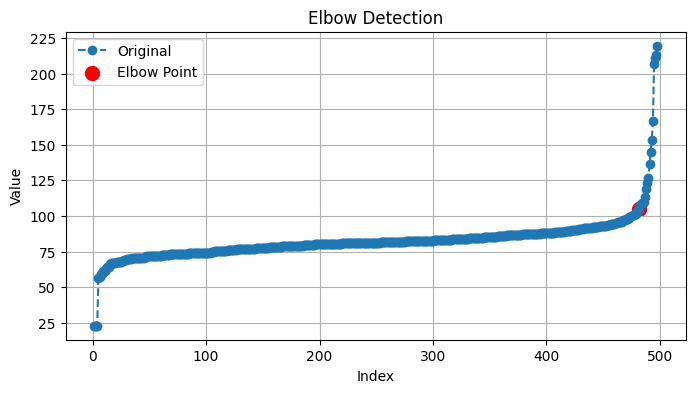

Optimal Value: 104.87730927135765
Elbow Index: 482


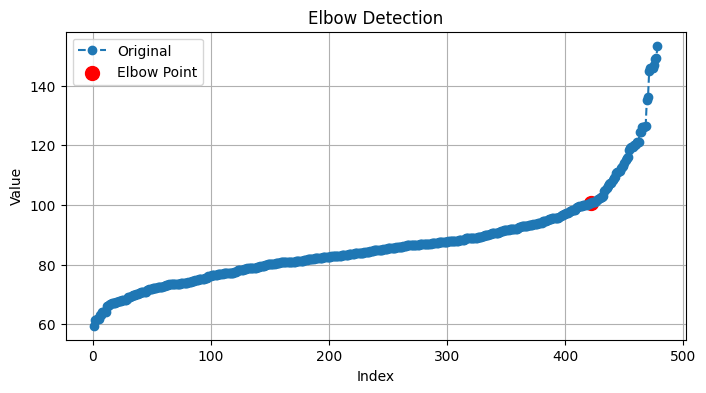

Optimal Value: 100.51119340650573
Elbow Index: 422


In [5]:
values = horizontal_distances
window_length = 5
polyorder = 2
smoothed_values = savgol_filter(values, window_length, polyorder)
z_scores = zscore(smoothed_values)
outlier_threshold = 3
non_outlier_indices = np.where(np.abs(z_scores) <= outlier_threshold)
non_outlier_values = [values[i] for i in non_outlier_indices[0]]
second_derivative = np.diff(np.diff(non_outlier_values))
elbow_index = np.argmax(second_derivative) + 2 
optimal_value = values[elbow_index - 1] 
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='--', label='Original')
plt.scatter(elbow_index, optimal_value, c='red', marker='o', label='Elbow Point', s=100)
plt.title('Elbow Detection');plt.xlabel('Index');plt.ylabel('Value');plt.grid(True);plt.legend();plt.show()
print(f'Optimal Value: {optimal_value}')
print(f'Elbow Index: {elbow_index}')

values = vertical_distances
values = values[10:-10]
window_length = 5
polyorder = 2
smoothed_values = savgol_filter(values, window_length, polyorder)
z_scores = zscore(smoothed_values)
outlier_threshold = 1.5
non_outlier_indices = np.where(np.abs(z_scores) <= outlier_threshold)
non_outlier_values = [values[i] for i in non_outlier_indices[0]]
second_derivative = np.diff(np.diff(non_outlier_values))
elbow_index = np.argmax(second_derivative) + 2 
optimal_value1 = values[elbow_index - 1] 
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='--', label='Original')
plt.scatter(elbow_index, optimal_value1, c='red', marker='o', label='Elbow Point', s=100)
plt.title('Elbow Detection');plt.xlabel('Index');plt.ylabel('Value');plt.grid(True);plt.legend();plt.show()
print(f'Optimal Value: {optimal_value1}')
print(f'Elbow Index: {elbow_index}')
for index, row in euclidean.iterrows():
    if(euclidean.at[index, 'Top_Box'][0] >= optimal_value1):
        euclidean.at[index, 'Top_Box'][1] = 0
        euclidean.at[index, 'Top_Box'][0] = -1
    if(euclidean.at[index, 'Bottom_Box'][0] >= optimal_value1):
        euclidean.at[index, 'Bottom_Box'][1] = 0
        euclidean.at[index, 'Bottom_Box'][0] = -1
    if(euclidean.at[index, 'Left_Box'][0] >= optimal_value):
        euclidean.at[index, 'Left_Box'][0] = -1
        euclidean.at[index, 'Left_Box'][1] = 0
    if(euclidean.at[index, 'Right_Box'][0] >= optimal_value):
        euclidean.at[index, 'Right_Box'][1] = 0
        euclidean.at[index, 'Right_Box'][0] = -1

```
read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]
```

In [6]:
img = cv2.imread('Bounding-Boxes/images/68.jpg')

```
Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format
```

In [7]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in initial_data.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)
  plt.imshow(img_2)

In [8]:
def make_connections(image):
#   print(image)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   print(image_rgb)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])
      
      # print(bottom_adjacent_id)
      
      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id-1].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id-1].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id-1].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id-1].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

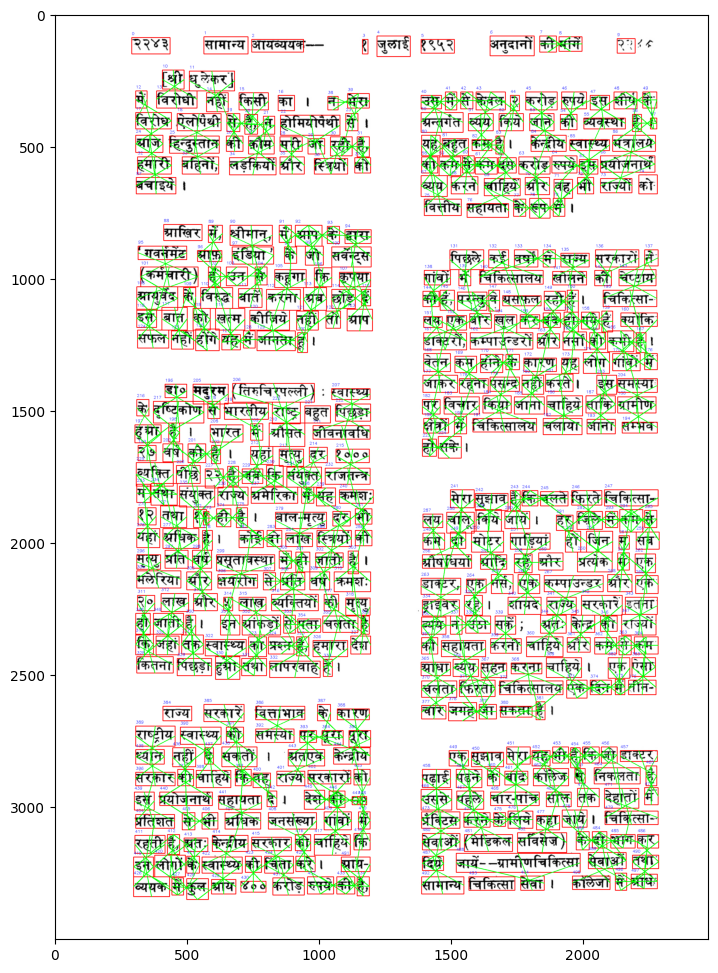

In [9]:
plt.figure(figsize=(20,12))
plt.imshow(make_connections(img))

# 4.3 - Guassian Mixture Models

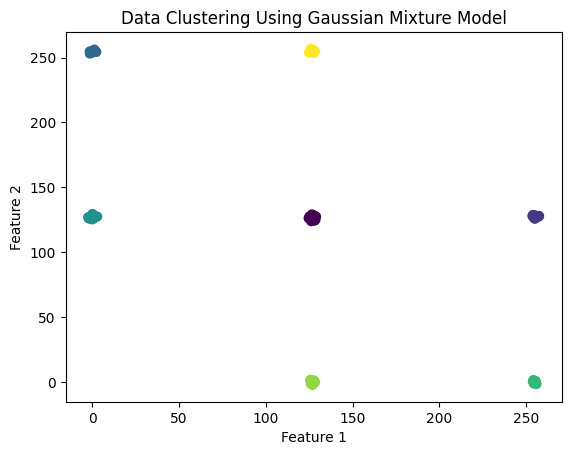

In [3]:

from sklearn.mixture import GaussianMixture
with open('colors.pkl', 'rb') as f:
    data = np.array(pickle.load(f))

X = data
gm = GaussianMixture(n_components=7, random_state=0).fit(X)
labels = gm.predict(X)
plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Clustering Using Gaussian Mixture Model')
plt.show()

/tmp/ipykernel_15919/2528036005.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(new_dataset[:, 0], new_dataset[:, 1], s=40, cmap='viridis')


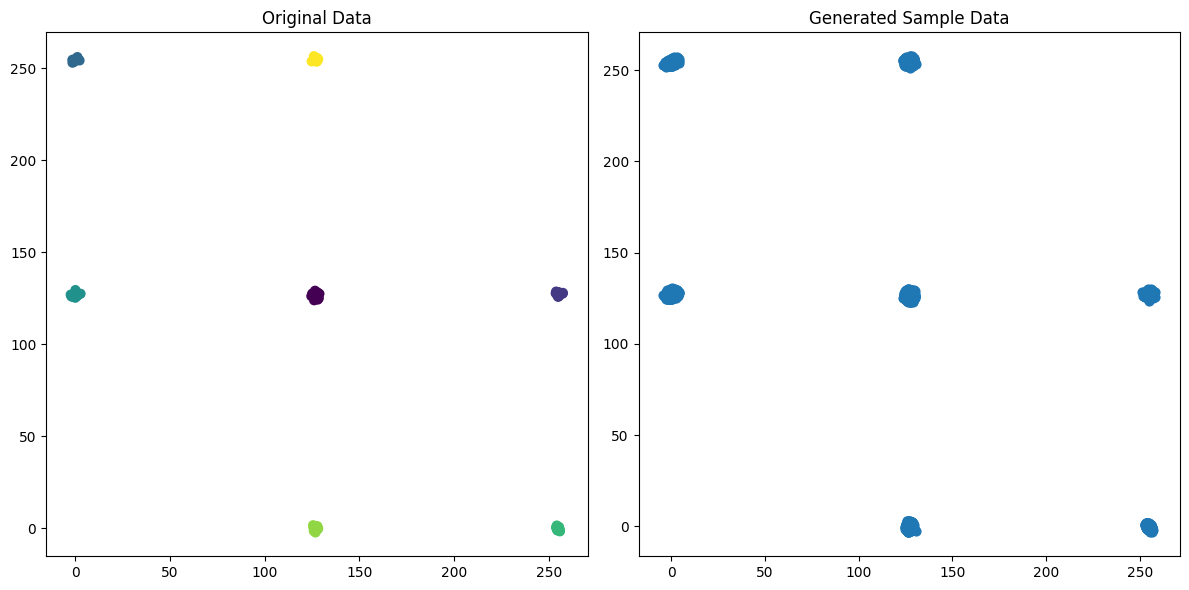

In [4]:
def generate_dataset(number_of_components,means,covariances,num_samples=1000):
    new_dataset = []
    for component in range(number_of_components):
        new_dataset.append(np.random.multivariate_normal(means[component],covariances[component],num_samples))
    return np.vstack(new_dataset)

new_dataset = generate_dataset(7,gm.means_,gm.covariances_)
plt.figure(figsize=(12, 6))

# Plot the original data on the left
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title('Original Data')

# Plot the generated data on the right
plt.subplot(1, 2, 2)
plt.scatter(new_dataset[:, 0], new_dataset[:, 1], s=40, cmap='viridis')
plt.title('Generated Sample Data')

plt.tight_layout()
plt.show()

```
The generated data has a similar distribution to the original data
The generated data appears to be a good fit for the original data. The two datasets have similar distributions, and the generated dataset shows a clear separation between the different components.
However, it is important to note that the generated dataset will be a random sample of the distribution, and there will be some variation in the data.
```

# Observations:
```
1. The generated data is slightly more spread out than the original data. This is likely due to the fact that the generated data is a random sample of the distribution, and there will be some variation in the data.
2. The generated data has slightly different covariances than the original data. This is also likely due to the fact that the generated data is a random sample of the distribution.
Overall, the plots suggest that the function generate_dataset() can be used to generate a good sample dataset with n likely components.
3. Overall, the plots suggest that the function generate_dataset() can be used to generate a good sample dataset with n likely components.

```

